In [1]:
import sys
sys.path.append('./ml-fastvit')
import os
import timm
import torch
import torch.optim as optim
import torchvision.utils as vutils
import torchvision.transforms as T
import torch.nn as nn
import models
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import gc

import cv2 as cv
from pathlib import Path
import pdb

from torch import Tensor
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm.models import create_model
from models.modules.mobileone import reparameterize_model
from PIL import Image
from urllib.request import urlopen

from UpsampleTransformerDecoder import UpsampleTransformerDecoder

from object_detection_utils import (
    read_directory_names_from_file,
    imshow,
    display_segmentation_map,
    list_image_files,
    read_tracks
)

# Before starting the training, make sure to clear any residual memory
gc.collect()
torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

If for semantic segmentation, please install mmsegmentation first
If for detection, please install mmdetection first
cuda


### Example Viz for Seg Map

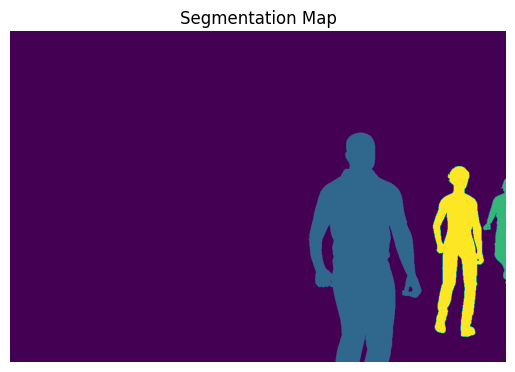

In [2]:
example_seg_map_path = 'datasets/UBNormal/Scene1/abnormal_scene_1_scenario_3_annotations/abnormal_scene_1_scenario_3_0191_gt.png'
seg_map = display_segmentation_map(example_seg_map_path)

### Example

In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image

def display_segmentation_map(image_path):
    # Load the image from the specified path
    segmentation_map = mpimg.imread(image_path)
    
    # Display the image
    plt.imshow(segmentation_map)
    plt.title('Segmentation Map')
    plt.axis('off')  # Hide the axes
    plt.show()

# def crop_and_place_object(segmentation_map_path, object_image_path, object_id, target_image_path, output_path):
#     segmentation_map = np.array(Image.open(segmentation_map_path))
#     object_image = np.array(Image.open(object_image_path))
#     target_image = np.array(Image.open(target_image_path))

#     # Create a mask for the object based on segmentation map
#     object_mask = (segmentation_map == object_id)

#     # Apply the mask to the object image
#     object_cropped = np.zeros_like(object_image)
#     for i in range(3):  # Assuming RGB image
#         object_cropped[:,:,i] = object_image[:,:,i] * object_mask

#     # Calculate scale factor if object is larger than the target image
#     scale_factor = min(target_image.shape[0] / object_cropped.shape[0],
#                        target_image.shape[1] / object_cropped.shape[1])
#     if scale_factor < 1.0:
#         new_size = (int(object_cropped.shape[1] * scale_factor), 
#                     int(object_cropped.shape[0] * scale_factor))
#         object_cropped = np.array(Image.fromarray(object_cropped).resize(new_size, Image.Resampling.LANCZOS))

#     # Update placement mask after scaling
#     placement_mask = np.sum(object_cropped, axis=-1) > 0  # Update for scaled object

#     # Random position to place the object in the target image
#     max_x = target_image.shape[0] - object_cropped.shape[0]
#     max_y = target_image.shape[1] - object_cropped.shape[1]
#     random_x = np.random.randint(0, max_x) if max_x > 0 else 0
#     random_y = np.random.randint(0, max_y) if max_y > 0 else 0

#     # Place the object in the target image
#     for i in range(object_cropped.shape[0]):
#         for j in range(object_cropped.shape[1]):
#             if placement_mask[i, j]:
#                 target_image[random_x + i, random_y + j] = object_cropped[i, j]

#     # Save the final image
#     Image.fromarray(target_image).save(output_path)

def crop_and_place_object(segmentation_map_path, object_image_path, object_id, target_image_path, output_path):
    segmentation_map = np.array(Image.open(segmentation_map_path))
    object_image = np.array(Image.open(object_image_path))
    target_image = np.array(Image.open(target_image_path))

    # Check if segmentation map and object image are of the same size
    if segmentation_map.shape[:2] != object_image.shape[:2]:
        # Resize segmentation map to match object image size
        segmentation_map = np.array(Image.fromarray(segmentation_map).resize(
            (object_image.shape[1], object_image.shape[0]), Image.NEAREST))

    # Create a mask for the object based on segmentation map
    object_mask = (segmentation_map == object_id)

    # Extend mask to 3D for RGB channels, if needed
    if object_image.ndim == 3 and object_mask.ndim == 2:
        object_mask = np.stack([object_mask]*3, axis=-1)

    # Apply the mask to the object image
    object_cropped = object_image * object_mask

    # Calculate scale factor if object is larger than the target image
    scale_factor = min(target_image.shape[0] / object_cropped.shape[0],
                       target_image.shape[1] / object_cropped.shape[1])
    if scale_factor < 1.0:
        new_size = (int(object_cropped.shape[1] * scale_factor), 
                    int(object_cropped.shape[0] * scale_factor))
        object_cropped = np.array(Image.fromarray(object_cropped).resize(new_size, Image.Resampling.LANCZOS))

    # Update placement mask after scaling
    placement_mask = np.any(object_cropped > 0, axis=-1)

    # Random position to place the object in the target image
    max_x = target_image.shape[0] - object_cropped.shape[0]
    max_y = target_image.shape[1] - object_cropped.shape[1]
    random_x = np.random.randint(0, max_x) if max_x > 0 else 0
    random_y = np.random.randint(0, max_y) if max_y > 0 else 0

    # Place the object in the target image
    for i in range(object_cropped.shape[0]):
        for j in range(object_cropped.shape[1]):
            if placement_mask[i, j]:
                target_image[random_x + i, random_y + j] = object_cropped[i, j]

    # Save the final image
    Image.fromarray(target_image).save(output_path)

# Example usage
segmentation_map_path = 'datasets/UBNormal/Scene1/abnormal_scene_1_scenario_3_annotations/abnormal_scene_1_scenario_3_0191_gt.png'
object_image_path = 'datasets/UBNormal/train_abnormal_frames/abnormal_scene_1_scenario_3/abnormal_scene_1_scenario_3_0191.jpg'
object_id = 1  # Assuming object ID is 1 in the segmentation map
target_image_path = 'datasets/Avenue Dataset/avenue_background.jpg'
output_path ='datasets/Avenue Dataset/example_ubnormal_placement.jpg'

crop_and_place_object(segmentation_map_path, object_image_path, object_id, target_image_path, output_path)


### Read Tracks

In [4]:
tracks_path = 'datasets/UBNormal/Scene1/abnormal_scene_1_scenario_3_annotations/abnormal_scene_1_scenario_3_tracks.txt'

data = read_tracks(tracks_path)
print(data)

[[2, 260, 360]]


### Flow for extracting anomalies onto Avenue Background

In [5]:
from natsort import natsorted

train_abnormal_vids_path = 'UBNormal/scripts/abnormal_training_video_names.txt'
train_abnormal_vids = natsorted(read_directory_names_from_file(train_abnormal_vids_path))
print(len(train_abnormal_vids), train_abnormal_vids[:3])

82 ['abnormal_scene_1_scenario_3', 'abnormal_scene_2_scenario_3', 'abnormal_scene_3_scenario_4']


In [51]:
output_path = "datasets/UBNormal/train_anomalies_avenue_background_frames/"
avenue_background_path = 'datasets/Avenue Dataset/avenue_background.jpg'
abnormal_train_frames_path = 'datasets/UBNormal/train_abnormal_frames/'

# Iterate through all videos in abnormal train dataset
for vid in train_abnormal_vids[25:]:
    print(vid)
    terms = vid.split("_")
    scene_no = terms[2]
    scenario_no = terms[-1]

    # We can construct the anootations, tracks paths, output_paths
    vid_annotations_path = f"datasets/UBNormal/Scene{scene_no}/{vid}_annotations/"
    tracks_path = os.path.join(vid_annotations_path, f"{vid}_tracks.txt")

    # Get abnormal frames images
    train_abnormal_frames_paths = natsorted(list_image_files(os.path.join(abnormal_train_frames_path, vid)))
    
    # Read seg map image names and natsort them
    seg_map_images_paths = natsorted(list_image_files(vid_annotations_path))

    assert len(train_abnormal_frames_paths) == len(seg_map_images_paths)

    # Read tracks
    tracks = read_tracks(tracks_path)
    
    # For each track, extract objects from anomaly frames given seg maps
    for track in tracks:
        obj_id, start, end = track
        
        for i in range(start, end):

            segmentation_map_path = seg_map_images_paths[i]
            object_image_path = train_abnormal_frames_paths[i]
            image_name = object_image_path.split("/")[-1].split(".")[0] # without extension
            image_save_path = os.path.join(output_path, vid, image_name + f"_{str(object_id)}.jpg")

            crop_and_place_object(segmentation_map_path, object_image_path, obj_id, avenue_background_path, image_save_path)
    


abnormal_scene_11_scenario_3_fog
abnormal_scene_11_scenario_4_fog
abnormal_scene_11_scenario_5
abnormal_scene_11_scenario_7
abnormal_scene_12_scenario_5
abnormal_scene_12_scenario_6
abnormal_scene_12_scenario_7
abnormal_scene_13_scenario_6
abnormal_scene_14_scenario_2
abnormal_scene_14_scenario_3
abnormal_scene_14_scenario_4
abnormal_scene_16_scenario_5
abnormal_scene_16_scenario_6
abnormal_scene_16_scenario_7
abnormal_scene_16_scenario_8
abnormal_scene_17_scenario_8
abnormal_scene_18_scenario_1
abnormal_scene_18_scenario_2
abnormal_scene_18_scenario_3
abnormal_scene_18_scenario_4
abnormal_scene_19_scenario_1
abnormal_scene_19_scenario_2
abnormal_scene_19_scenario_3
abnormal_scene_19_scenario_4
abnormal_scene_20_scenario_5
abnormal_scene_20_scenario_6
abnormal_scene_20_scenario_7
abnormal_scene_20_scenario_8
abnormal_scene_20_scenario_9
abnormal_scene_21_scenario_5
abnormal_scene_21_scenario_6
abnormal_scene_21_scenario_7
abnormal_scene_21_scenario_9
abnormal_scene_22_scenario_6
abnorm